# Load libraries and data

In [1]:
import pandas as pd
import statsmodels.api as sm

In [2]:
delta = pd.read_csv('DAL.csv')
aa = pd.read_csv('AAL.csv')

# Merge datasets

In [3]:
delta['Date'] = pd.to_datetime(delta['Date'])
aa['Date'] = pd.to_datetime(aa['Date'])

aa.set_index('Date',inplace=True) # replace dataset index with "Date" column
delta.set_index('Date',inplace=True) 

merged_data = pd.merge(aa,delta,left_index=True,right_index=True)

# Plot closing prices

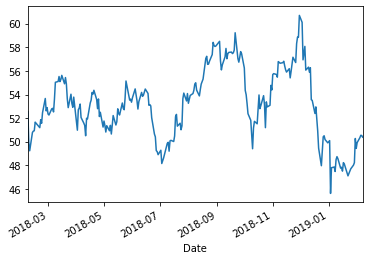

In [5]:
merged_data['Adj Close_y'].plot()

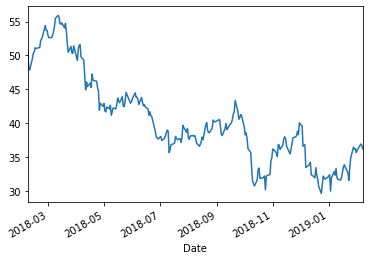

In [6]:
merged_data['Adj Close_x'].plot()

# Look at Jul-2018  - Dec-2019 sub-sample only 

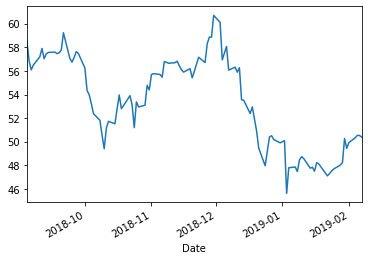

In [21]:
merged_data.iloc[(merged_data.index > '2018-09-01') & (merged_data.index < '2019-12-01')]['Adj Close_y'].plot()

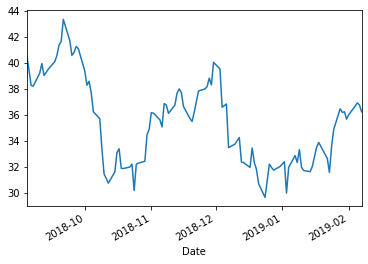

In [20]:
merged_data.iloc[(merged_data.index > '2018-09-01') & (merged_data.index < '2019-12-01')]['Adj Close_x'].plot()

# Test for cointegration: Full Sample

In [9]:
merged_data = sm.add_constant(merged_data)
full_sample_model = sm.OLS(merged_data['Adj Close_y'],merged_data[['const','Adj Close_x']]).fit()
full_sample_model.summary()

/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Adj Close_y   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     8.736
Date:                Tue, 07 Jan 2020   Prob (F-statistic):            0.00342
Time:                        18:13:20   Log-Likelihood:                -623.83
No. Observations:                 252   AIC:                             1252.
Df Residuals:                     250   BIC:                             1259.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          49.8092      1.145     43.520      0.000      47.555      52.063
Adj Close_x     0.0826      0.028      2.956      0.003       0.028       0.138
==============================================================================
Omnibus:                       11.663   Durbin-Watson:                   0.091
Prob(Omnibus):                  0.003   Jarque-Bera (JB):                6.827
Skew:                           0.231   Prob(JB):                       0.0329
Kurtosis:                       2.340   Cond. No.                         258.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

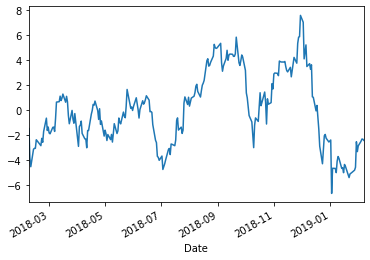

In [10]:
full_sample_model.resid.plot()

In [14]:
adf_test_result = sm.tsa.stattools.adfuller(full_sample_model.resid,maxlag=1)
print(adf_test_result)

(-2.158370274609309, 0.22169991772129616, 1, 250, {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544}, 629.9033245532771)


# Back-test simple pairs trading strategy

In [56]:
days_in_sample = merged_data.shape[0]
starting_date = 30

Generate trade signals

In [100]:
signals = []

for i in range(starting_date,days_in_sample):
    
    regression_data = merged_data.iloc[0:i,:]
    current_model = sm.OLS(regression_data['Adj Close_y'],regression_data[['const','Adj Close_x']]).fit()
    
    current_signal = current_model.resid[-1] # get last model residual, if this is >0 - DAL is overpriced, if <0 - AAL is overpriced
    signals = signals + [current_signal]

Add trade signals to dataframe

In [124]:
merged_data['TradeSignal'] = ''
merged_data['TradeSignal'].iloc[starting_date:] = signals

In [125]:
merged_data.tail()

,const,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_x,Open_y,High_y,Low_y,Close_y,Adj Close_y,Volume_y,TradeSignal
Date,,,,,,,,,,,,,,
2019-02-01,1.0,35.770000,36.590000,35.770000,36.110001,36.011822,6611900,49.630001,50.490002,49.570000,49.919998,49.919998,6172900,-3.39757
2019-02-04,1.0,36.160000,36.810001,36.119999,36.779999,36.680000,9089300,49.990002,50.400002,49.560001,50.340000,50.340000,5356200,-2.91653
2019-02-05,1.0,36.810001,37.230000,36.700001,36.930000,36.930000,6003200,50.369999,51.060001,50.020000,50.540001,50.540001,8727600,-2.53564
2019-02-06,1.0,36.799999,37.090000,36.610001,36.759998,36.759998,5801800,50.169998,50.779999,49.860001,50.520000,50.520000,6224800,-2.34343
2019-02-07,1.0,36.459999,36.700001,35.939999,36.240002,36.240002,3878459,50.340000,50.668800,49.970001,50.380001,50.380001,3591066,-2.3373


In [128]:
merged_data['DAL_Return'] = merged_data['Adj Close_y'].pct_change()
merged_data['AAL_Return'] = merged_data['Adj Close_x'].pct_change()

In [131]:
merged_data = merged_data.iloc[30:,:] # drop first 30 observations for which trade signal is not available

In [134]:
DAL_short_trade = merged_data['TradeSignal'] > 0
DAL_long_trade = merged_data['TradeSignal'] < 0